In [ ]:
import os 
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat
from scipy.signal import resample
from pathlib import Path



In [ ]:
arr = np.array([1,2,3])
arr[:-1]

# DaLiA Dataset

In [ ]:
data_path = "C:/Users/cleme/ETH/Master/Thesis/data/DaLiA/data/PPG_FieldStudy"
participant_paths = glob.glob(os.path.join(data_path, '**', '*_quest.csv'), recursive=True)
series = []
for participant in participant_paths:
   row = pd.read_csv(participant, header=None).T
   row.columns = [el.split(" ")[1] for el in row.iloc[0]]
   row = row.drop(row.index[0])
   series.append(row) 

df = pd.concat(series, ignore_index=True)
df

In [ ]:
import pickle

with open(data_path + "/S1/S1.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")
data

In [ ]:
acc = data['signal']['wrist']['ACC']
time = 8 + 2 * (data['label'].shape[0] - 1)
print(time)
print(acc.shape[0] / 32)

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

# Input data (replace with your actual data)
vec = acc[:,0]

# Parameters
window_size = 256  # 8 seconds at 32Hz
stride = 64        # 2 seconds at 32Hz

# Compute sliding window mean
windows = sliding_window_view(vec, window_shape=window_size)[::stride]
window_means = np.mean(windows, axis=1)

# Output shape
print("Window means shape:", window_means.shape)

In [ ]:
data['label'].shape

In [ ]:
import numpy as np

# Example vector
x = acc[:,0]  # or whatever your 1D array is

# Parameters
window_size = 256
stride = 64

print((x.size - window_size)// stride + 1)

# Create the sliding windows
shape = ((x.size - window_size) // stride + 1, window_size)
strides = (x.strides[0] * stride, x.strides[0])
windows = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

# Compute the mean for each window
means = windows.mean(axis=1)
means.shape


In [ ]:
acc[:,0].shape[0] / 32

In [ ]:
rpeaks = data['rpeaks']
print(rpeaks.shape)
rpeaks = rpeaks / 700.0
rr_intervals = np.diff(rpeaks)
hr = 60 / rr_intervals 
pd.Series(hr[:100]).plot()

In [ ]:
pd.Series(data['label'][:100]).plot()

In [ ]:
data['signal']['wrist']['ACC'].shape

In [ ]:
294784 / 11431

In [ ]:
len(np.where(data['activity']==1.0)[0]) 

In [ ]:
data_path = "C:/Users/cleme/ETH/Master/Thesis/data/euler"
np_data = np.load(data_path + "/dalia_preprocessed/S1.npz")

def scale(data):
    return (data - np.mean(data)) / (np.std(data) + 1e-8)

series = np_data['bvp'][:, 0]
series = scale(series)

activity = resample(np_data['wrist_acc'], len(np_data['bvp']))
activity = activity[:,0]**2 + activity[:, 1]**2 + activity[:,2]**2
activity = scale(activity)

highest_activity = np.argmax(activity)
lower = max(highest_activity-1000,0)
upper = min(highest_activity+1000,len(np_data['bvp']))
serie = pd.Series(series[lower: upper])
serie.plot(alpha=0.5)
activity = pd.Series(activity[lower:upper])
activity.plot(alpha=0.5)
plt.legend()

In [ ]:
pd.Series(data['signal']['chest']['ECG'][:1400][:,0]).plot()

In [ ]:
data['signal']['wrist']['BVP']

# UCIHAR Dataset

In [ ]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/UCIHAR/UCI HAR Dataset/UCI HAR Dataset/"
data = np.load(datadir + "ucihar_preprocessed.npz")
data

In [ ]:
data['train_val_subjects'].shape[0] == data['X_train'].shape[0]

In [ ]:
data['X_test'].shape[0] == data['y_test'].shape[0]

In [ ]:
pd.Series(data['y_train']).unique()

In [ ]:
inertial = "C:/Users/cleme/ETH/Master/Thesis/data/euler/UCIHAR/train/Inertial Signals/"
data_x = np.loadtxt(inertial + "total_acc_x_train.txt")
data_x.shape

In [ ]:
y_train = np.loadtxt(datadir + "train/y_train.txt")
y_test = np.loadtxt(datadir + "test/y_test.txt")
print(pd.Series(y_train).unique())
print(pd.Series(y_test).unique())

In [ ]:
body_acc_x = np.loadtxt(datadir + "Inertial Signals/body_acc_x_train.txt")

In [ ]:
print(x_train.shape)

In [ ]:
pd.Series(subjects).unique()

# USC Dataset

In [ ]:

datadir = "C:/Users/cleme/ETH/Master/Thesis/data/USC/USC-HAD/"
file_dir = datadir + "Subject1/a1t1.mat"
data = loadmat(file_dir)
data

In [ ]:

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[list(range(1, 13))], sparse_output=False)
encoder.fit_transform(np.array(['11']).astype(int)[np.newaxis,:])

In [ ]:
subjects = {"age" : [], "height": [], "weight": []}
for i in range(1,15):
    file_dir = datadir + f"Subject{i}/a1t1.mat"
    data = loadmat(file_dir)
    subjects['age'].append(int(data['age'][0]))
    subjects['height'].append(int(data['height'][0][:3]))
    subjects['weight'].append(int(data['weight'][0][:2]))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

data = pd.DataFrame(subjects)

# Use KMeans to create clusters (diversity groups)
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['age', 'height', 'weight']])

# Stratify by cluster to maintain diversity
train_val, test = train_test_split(data, test_size=3, stratify=data['cluster'], random_state=42)
train, val = train_test_split(train_val, test_size=3, stratify=train_val['cluster'], random_state=42)

# Drop cluster column before using
train = train.drop(columns='cluster')
val = val.drop(columns='cluster')
test = test.drop(columns='cluster')

print("Train subjects:\n", sorted(train.index + 1))
print("\nValidation subjects:\n", sorted(val.index + 1))
print("\nTest subjects:\n", sorted(test.index + 1))

# Capture 24

In [1]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/Capture24/capture24"
df = pd.read_csv(datadir + "/P001.csv")
df

NameError: name 'pd' is not defined

In [10]:
no_time = df.drop(["time"], axis=1)
downsampled = no_time.iloc[::4]  # downsample by factor of 4 | 100Hz => 25Hz
downsampled["annotation"] = downsampled["annotation"].str.split().str[-1].astype(float)
downsampled["annotation"] = downsampled["annotation"].interpolate()
no_index = downsampled.reset_index(drop=True)
no_index



C:\Users\cleme\AppData\Local\Temp\ipykernel_13892\361741359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downsampled["annotation"] = downsampled["annotation"].str.split().str[-1].astype(float)
C:\Users\cleme\AppData\Local\Temp\ipykernel_13892\361741359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downsampled["annotation"] = downsampled["annotation"].interpolate()


,x,y,z,annotation
0,-0.466690,-0.533341,0.658472,0.95
1,-0.466690,-0.533341,0.658472,0.95
2,-0.466690,-0.533341,0.658472,0.95
3,-0.482334,-0.533341,0.658472,0.95
4,-0.466690,-0.533341,0.673867,0.95
...,...,...,...,...
2504996,0.049416,-0.782285,0.565700,0.95
2504997,0.049416,-0.782285,0.565700,0.95
2504998,0.049416,-0.782285,0.565700,0.95
2504999,0.049416,-0.797846,0.565700,0.95


<Axes: >

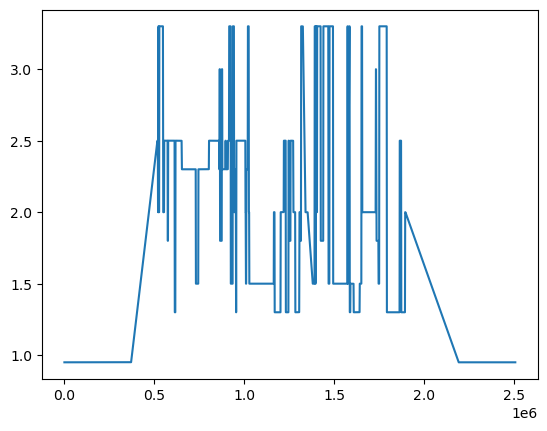

In [13]:
no_index['annotation'].plot()

,x,y,z,annotation


# WildPPG

In [ ]:
datadir="C:/Users/cleme/ETH/Master/Thesis/data/euler/wildppg_preprocessed/"
file_path = datadir + "WildPPG_Part_an0.npz"
data = np.load(file_path)

In [ ]:
datadir="C:/Users/cleme/ETH/Master/Thesis/data/euler/wildppg_preprocessed/WildPPG.mat"
data = loadmat(datadir)


In [ ]:
data['data_imu_wrist'][0,0].shape

In [ ]:
arr = np.array([[1,2,3,4]]).T
print(arr.shape)
np.repeat(arr, 4,axis=1).shape

In [ ]:
activity = data['data_imu_wrist'][0,0]
pd.Series(activity.squeeze()).plot()

In [ ]:
hr = data['data_bpm_values'][i,0]
print(hr.shape)
pd.Series(hr.squeeze()).plot()

In [ ]:
for i in range(16):
    hr = data['data_bpm_values'][i,0]
    activity = data['data_imu_wrist'][i,0]
    ppg = data['data_ppg_wrist'][i, 0]
    print(hr.shape)
    print(activity.shape)
    print(ppg.shape)

In [ ]:
any(pd.Series(data['data_bpm_values'][0,0].astype(int).squeeze()).isna())

In [ ]:
data['data_ppg_wrist'][0][0].shape

In [ ]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/WildPPG/data"
file_pat = datadir + "/WildPPG_Part_an0.mat"
data = loadmat(file_pat)

In [ ]:
data['sternum']

In [ ]:
ecg = data['sternum']['ecg'][0][0][0][0][2].squeeze()

In [ ]:
import neurokit2 as nk 
signals, info = nk.ecg_process(ecg, sampling_rate=128)

In [ ]:
ecg_time = ecg.shape[0] / 128
time_rpeaks = info['ECG_R_Peaks'] / 128
diffed = np.diff(time_rpeaks)
hr = 60 / diffed 
window_size = 128 * 8 
stride = 128 * 2 
ecg_time

In [ ]:
pd.Series(data['sternum']['ecg'][0][0][0][0][2].squeeze(0)[:1000]).plot()

In [ ]:
print(data['wrist']['ppg_g'][0][0][0]['v'][0].shape)
print(data['wrist']['ppg_r'][0][0][0]['v'][0].shape)
print(data['wrist']['ppg_ir'][0][0][0]['v'][0].shape)

In [ ]:
from pathlib import Path 
datadir = Path(datadir)
lengths = []
for path in datadir.glob('*.mat'):
    data = loadmat(path)
    lengths.append(data['wrist']['acc_x'][0][0][0][0][2].shape[1])
    del data

In [ ]:
lengths

In [ ]:
names = []
for path in datadir.glob("*.mat"):
    names.append(str(path).split("_")[-1][:3])
names

# IEEE Dataset

The IEEE Dataset does not contain any activity labels or acceleration data. 

In [ ]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/euler/IEEEPPG/Training_data/Training_data"
data = loadmat(datadir + "/DATA_01_TYPE01.mat")
hr = loadmat(datadir + "/DATA_01_TYPE01_BPMtrace.mat")


In [ ]:
signal_files = Path(datadir).glob("*[12].mat")
bpm_files = Path(datadir).glob("*_BPMtrace.mat")

fs = 125  # sampling rate
window_duration = 8
overlap_duration = 6 

from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler

def filter_butter(x, fs):
    f1 = 0.5
    f2 = 4
    Wn = [f1, f2]
    N = 4
    b, a = butter(N, Wn, btype="bandpass", fs=fs)
    filtered = filtfilt(b, a, x)
    # Normalize to range [0, 1]
    scaler = MinMaxScaler()
    filtered = scaler.fit_transform(filtered.reshape(-1, 1)).flatten()
    return filtered

def preprocess_signal(signal: np.ndarray):
    # create windows
    windows = sliding_window_view(signal, window_shape=window_duration * fs)[
        :: (window_duration - overlap_duration) * fs
    ]
    # downsample from 125Hz => 25Hz
    downsampled_windows = windows[:, ::5]

    return downsampled_windows

participant_signals = []
participant_bpms = []
for i,(signal_file, bpm_file) in enumerate(zip(signal_files, bpm_files)):

    signals = loadmat(signal_file)["sig"]
    bpm = loadmat(bpm_file)['BPM0']

    ppg1 = filter_butter(signals[1], fs)
    ppg2 = filter_butter(signals[2], fs)
    acc_x = filter_butter(signals[3], fs)
    acc_y = filter_butter(signals[4], fs)
    acc_z = filter_butter(signals[5], fs)

    avg_ppg = (ppg1 + ppg2) / 2
    acc = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    ppg = preprocess_signal(avg_ppg)[:, :, np.newaxis]  # add concatenation axis
    acc = preprocess_signal(acc)[:, :, np.newaxis]
    combined_signal = np.concatenate((ppg, acc), axis=-1)  # Shape (W, T, 2)

    signal_data = combined_signal[:-1]
    if len(signal_data) != len(bpm):
        print(
                f"bpm {len(bpm)}and signal_data {len(signal_data)} are not the same shape "
        )
        signal_data = combined_signal[:]         
      

    print(len(signal_data))
    print(len(bpm))
    assert len(signal_data) == len(bpm)

    participant_signals.append(signal_data)
    participant_bpms.append(bpm)


stacked_signals = np.stack(participant_signals, axis=0)
stacked_bpms = np.stack(participant_bpms, axis=0)

In [ ]:
data['sig'][0]

In [ ]:
hr['BPM0'].shape

In [ ]:
data['whole_dataset'][0][0]

# Chapman 

In [ ]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/Chapman/"
data = loadmat(datadir + "chapman.mat")


In [ ]:
data['whole_data'][0][0].shape

In [ ]:
df = pd.DataFrame(data['whole_data'])
df[0].values[1].shape

In [ ]:
df = pd.DataFrame(data['whole_data'])[1].apply(lambda x: x[0][0])
plt.hist(df.values)
print(df.unique())